Though data is already given to us preprocessed, we will run several tests to make sure that the data does not have too much multicollinearity. We will also perform feature selection and look for outliers.

## 1. Read dataset and begin pre-processing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

class Reader:
    def __init__(self, path, mode='f'):
        
        self.df = self.wrapper(path,mode)
    
    # read arff file
    def readarff(self, filename,collect=True): #collect if you need to collect attribute names
        with open(filename) as f:
            content = f.read().splitlines()
        data = False
        metalist = [] # storets metadata as list of rows
        datalist = [] # store data as list of rows
        
        # read data line-by-line
        for line in content:
            if data == True:
                line = line.split(",")
                datalist.append(line)
            elif line == "@data":
                data = True # read lines before "@data" as metadata and after as data
            else:
              # clean up metadata header
              if collect:
                line = line.replace(' "', ".")
                line = line.replace('" ', ".")
                line = line.replace(" ","")
                line = line.split(".")
                if len(line)==3: #ignore first two lines of file
                    line = line[1:3] #remove repetitive "@attribute"
                    metalist.append(line)
        
        # create dataframes from lists of rows
        if not collect:
            dataframe = pd.DataFrame(datalist,dtype=float)
            return dataframe
        else:
            dataframe = pd.DataFrame(datalist,dtype=float)
            metaframe = pd.DataFrame(metalist,columns=["attribute","description"])
            attributes = metaframe["attribute"].rename("SAMPLE")
            return dataframe, attributes
    
    def readdirectory(self, path,quiet=False): # make sure path ends in a slash
        alldata = []
        count = 0
        for filename in os.listdir(path):
            if filename.endswith(".arff"):
                if count == 0: #only collect attributes once
                    if not quiet:
                          print("processing "+filename+"; collecting attribute names")
                    dataframe, attributes = self.readarff(path+filename)
                    alldata.append(dataframe)
                else:
                    if not quiet:
                        print("processing "+filename)
                    dataframe = self.readarff(path+filename,collect=False)
                    alldata.append(dataframe)
                count += 1
                continue
            else:
                continue
        if not quiet:
            print("Concatenating data")
        alldata = pd.concat(alldata).reset_index(drop=True) #reset indices so it is continuous
        alldata.columns = attributes #assign column names
        return alldata
    
    def wrapper(self, path, mode='f'):
        if mode == 'f':
            try:
                df =  self.readarff(path, collect = True)
                return df
            except:
                print("make sure you inputted the correct arff FILE path")
        elif mode == 'd':
            try:
                df =  self.readdirectory(path, quiet=True)
                return df
            except:
                print("make sure you inputted the correct arff DIRECTORY path, ending with a slash")
        else:
            print("mode must either be 'f' or 'd'")
            return 0

In [2]:
df = Reader("phone_accel/",mode='d').df

The pre-process function will select the attributes of interest, seperate the dependent variable from the independent variables, and perform one hot encoding on the dependent variable because it is categorical. Also, this function includes normalization.

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
    
def preprocess(df, attributes, class_label, testsize, normalize=True):
        """
        attributes = list of desired attribute names
        class_label = string of the desired class label
        """
        # define X
        X = df[attributes]
        
        # Normalize data
        if normalize:
            scaler = MinMaxScaler()
            X = pd.DataFrame(scaler.fit_transform(X))
            
        # define Y
        Y = df[class_label]
        encoder = LabelEncoder() # encoder stores conversion between class values (str) and identifiers (int)
        encoder.fit(Y)
        Y = encoder.transform(Y)
        Y = pd.get_dummies(Y) # convert to one hot encoded form
        
        # output combined df
        df = pd.concat([X, Y], axis=1)
        return df, X, Y

# list attributes and label of choice
attributes = ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
       'Y0', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Z0', 'Z1',
       'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'XAVG', 'YAVG', 'ZAVG',
       'XPEAK', 'YPEAK', 'ZPEAK', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV',
       'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV', 'XVAR', 'YVAR', 'ZVAR', 'RESULTANT']
label = 'ACTIVITY'
testsize = 0.3 # use a 70/30 train/test split  

# preprocess data
df_processed, X, Y= preprocess(df, attributes, label, testsize)
df_processed

,0,1,2,3,4,5,6,7,8,9,...,8,9,10,11,12,13,14,15,16,17
0,0.060,0.110,0.215,0.255,0.240,0.070,0.030,0.033898,0.029412,0.014925,...,0,0,0,0,0,0,0,0,0,0
1,0.050,0.130,0.170,0.220,0.285,0.090,0.020,0.067797,0.058824,0.014925,...,0,0,0,0,0,0,0,0,0,0
2,0.070,0.135,0.165,0.250,0.190,0.130,0.025,0.050847,0.058824,0.029851,...,0,0,0,0,0,0,0,0,0,0
3,0.075,0.145,0.140,0.205,0.275,0.105,0.010,0.084746,0.117647,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,0.085,0.145,0.145,0.175,0.285,0.100,0.030,0.067797,0.029412,0.029851,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23069,0.085,0.870,0.045,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,1
23070,0.045,0.930,0.025,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,1
23071,0.115,0.850,0.035,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,1
23072,0.085,0.850,0.060,0.005,0.000,0.000,0.000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,1


## 2. Find and remove outliers
The findOutliers function identifies outliers and returns them. Since it only returns outliers at the intersection of the results from the LocalOutlierFactor and IsolationForest methods, it would seem that these outliers are safe to remove.

In [4]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

def findOutliers(df):
    """
    Function that takes in a dataframe and returns outliers that are identified by both 
    the LocalOutlierFactor and Isolation Forest methods.
    """
    # identify outliers with LocalOutlierFactor
    lof = LocalOutlierFactor()
    pred_lof = lof.fit_predict(df)

    # identify outliers with IsolationForest
    isoforest = IsolationForest()
    pred_isoforest = isoforest.fit_predict(df)
    
    # identify outliers at the intersection of both methods
    outliers = np.intersect1d(np.where(pred_lof == -1), np.where(pred_isoforest == -1))
    
    return outliers

In [5]:
outliers = findOutliers(df_processed)
df_clean = df_processed.drop(outliers)

We can see how our dataframe has changed through this process by comparing the sizes of the dataframes.

In [6]:
print("raw data shape:",df.shape)
print("processed data shape:",df_processed.shape)
print("outlier-free data shape:",df_clean.shape)

raw data shape: (23074, 93)
processed data shape: (23074, 64)
outlier-free data shape: (23041, 64)


## 3. Look for multicollinearity

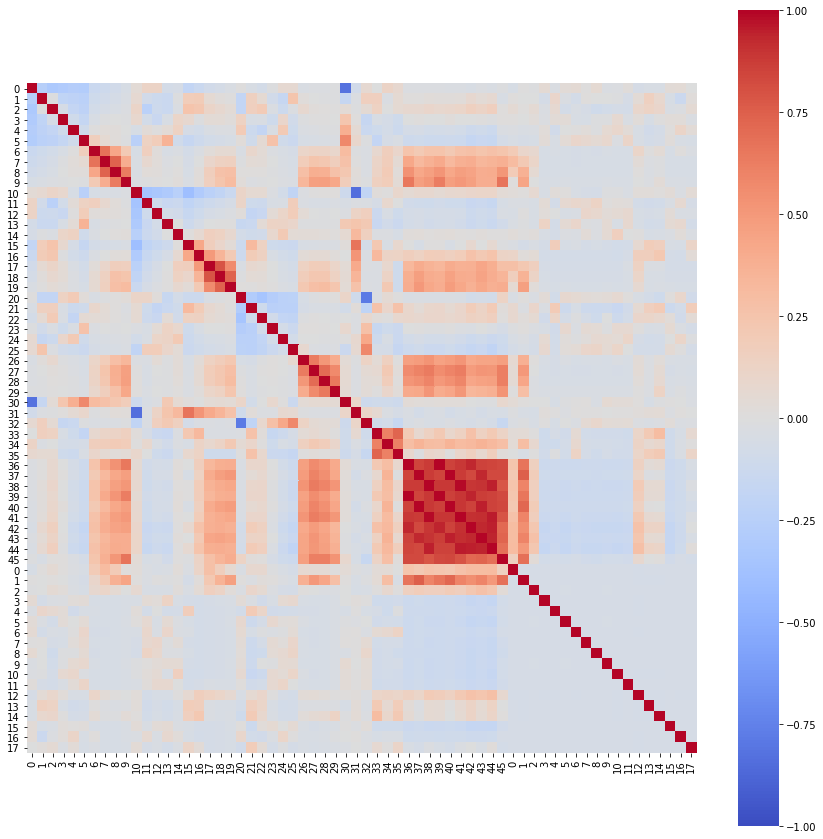

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

def heatmap(df):
    fig, ax = plt.subplots(figsize=(15,15))
    sns.heatmap(df.corr(),annot=False, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm',square=True,ax=ax)

# perform heatmap
heatmap(df_clean)

We see significant multicollinearity between attributes 36-45. However, since we are going for the highest prediction accuracy, it is not necessary to remove these features.